In [ ]:
import json
import copy
import struct
import h5py
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import open3d as o3d
from open3d.visualization import rendering

from tqdm import tqdm
from typing import List
from pathlib import Path
from plyfile import PlyData, PlyElement
from collections import defaultdict
from collections import deque

from scripts.kdtree import recursive_kd_partition_with_path, group_partitions_by_prefix
from scripts.octree import build_octree_max_partitions, build_octree_max_points
from scripts.helpers import visualize_partitions, rotation_to_align_plane
from scripts.evaluate import compute_all_partition_metrics, plot_partition_metrics
from scripts.hdf5_writer import write_partition_hdf5

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Load and visualise a scene as a point cloud

Configure the dataset directory and scene name.

It expects a trained Radiant Foam model saved as a PLY file named \<scene_name\>.ply inside your dataset directory.

In [2]:
dataset_dir = Path("./data")
plots_dir = Path("./plots")
plots_dir.mkdir(parents=True, exist_ok=True) 

scene_name = "bicycle"
ply_filename = dataset_dir / f"{scene_name}.ply"
h5_filename = dataset_dir / f"{scene_name}.h5"

# Load the trained model
plydata = PlyData.read(ply_filename)

vertices = plydata.elements[0]
adjacency = plydata.elements[1]
print(f"Scene: {scene_name}")
print(f"Number of vertices: {len(vertices)}")
print(f"Number of adjacencies: {len(adjacency)}")

adjacency_offsets = vertices['adjacency_offset']
adjacencies = adjacency['adjacency']

# Visualize in Open3D
points = np.vstack([vertices['x'], vertices['y'], vertices['z']]).T
colors = np.vstack([vertices['red'], vertices['green'], vertices['blue']]).T / 255.0

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
pcd.colors = o3d.utility.Vector3dVector(colors)

# Rotate point cloud using loaded rotation matrix
R = rotation_to_align_plane(pcd, distance_threshold=0.01)
rotated_pcd = pcd.rotate(R, center=(0, 0, 0))
rotated_points = points @ R.T 

coord_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5)
o3d.visualization.draw_geometries([rotated_pcd, coord_frame])

Scene: bicycle
Number of vertices: 4199873
Number of adjacencies: 63719194


## Scene partitioning with KD-Tree

In [3]:
N_CLUSTERS = 1024
print(f"Partioning {len(points)} points to {N_CLUSTERS} clusters")

kd_partitions_with_paths = recursive_kd_partition_with_path(rotated_points, max_partitions=1024)
partitioned_points = [points[indices] for indices, _ in kd_partitions_with_paths]

visualize_partitions(partitioned_points, show_bounding_boxes=True)

Partioning 4199873 points to 1024 clusters


PointCloud with 4199873 points.

### Grouping back KD-Partitioned parts

In [4]:
group_depth = 7
grouped = group_partitions_by_prefix(kd_partitions_with_paths, prefix_length=group_depth)
grouped_pointclouds = [points[indices] for indices in grouped.values()]
visualize_partitions(grouped_pointclouds, False)

PointCloud with 4199873 points.

### Saving to HDF5

In [5]:
ply = PlyData.read(ply_filename)

vtx = ply["vertex"].data  
adj = ply["adjacency"]["adjacency"].astype(np.uint32) 

N   = len(vtx)

unrotated_pts = np.column_stack([vtx["x"], vtx["y"], vtx["z"]]).astype(np.float32)
pts = unrotated_pts @ R.T 
colours  = np.column_stack([vtx["red"], vtx["green"], vtx["blue"]]).astype(np.uint8)
density  = vtx["density"].astype(np.float32)
adj_idx  = vtx["adjacency_offset"].astype(np.uint32)

print(f"Loaded PLY: {N:,} verts  |  {adj.size:,} Adjacencies")

N_CLUSTERS = 1024
kd_partitions_with_paths = recursive_kd_partition_with_path(pts, max_partitions=N_CLUSTERS)
print(f"KD-Tree partitioned scene into {N_CLUSTERS} clusters")

Loaded PLY: 4,199,873 verts  |  63,719,194 Adjacencies
KD-Tree partitioned scene into 1024 clusters


In [6]:
writer_summary = write_partition_hdf5(h5_filename, pts, colours, density, kd_partitions_with_paths, adj_idx, adj)

part    0:   4,101 local |    818 neighbours from 14 clusters | adjacency list    61,338
part  128:   4,101 local |  1,292 neighbours from 16 clusters | adjacency list    61,951
part  256:   4,101 local |  1,884 neighbours from 57 clusters | adjacency list    61,417
part  384:   4,101 local |  1,082 neighbours from  8 clusters | adjacency list    62,755
part  512:   4,101 local |  1,758 neighbours from 48 clusters | adjacency list    60,971
part  640:   4,101 local |  1,771 neighbours from 40 clusters | adjacency list    62,390
part  768:   4,101 local |    801 neighbours from 14 clusters | adjacency list    61,491
part  896:   4,101 local |  1,059 neighbours from 35 clusters | adjacency list    61,427
✓ 1024 partitions written to data/bicycle.h5


### Plot partition metrics

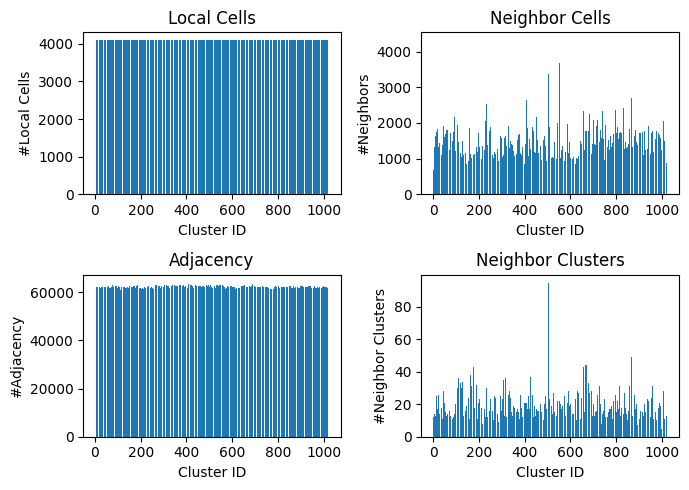

In [7]:
plot_partition_metrics(writer_summary, save_filename=plots_dir / f"{scene_name}_kdtree_partition_result.pdf")

In [8]:
top_N = 10
np_arr = np.array(writer_summary['num_adjacency_lengths'])
indices = np.argsort(np_arr)[-top_N:]
n_largest = np_arr[indices]

print(f"Largest {top_N} adjacencies: {n_largest}")  

np_arr = np.array(writer_summary['num_neighbor_clusters'])
indices = np.argsort(np_arr)[-top_N:]
n_largest = np_arr[indices]

print(f"Largest {top_N} neighbour clusters: {n_largest}")  

np_arr = np.array(writer_summary['num_neighbor_pts'])
indices = np.argsort(np_arr)[-top_N:]
n_largest = np_arr[indices]

print(f"Largest {top_N} neighbour cells: {n_largest}")  

Largest 10 adjacencies: [63279 63307 63316 63355 63361 63414 63459 63509 63847 64010]
Largest 10 neighbour clusters: [57 57 58 58 60 64 67 67 81 95]
Largest 10 neighbour cells: [3026 3058 3069 3269 3288 3344 3362 3648 3667 4322]


## Octree with max points constraint

In [9]:
MAX_PTS_PER_NODE = 5000
indices_octree_w_max_pts = build_octree_max_points(pts, max_points_per_node=MAX_PTS_PER_NODE)
print(f"Number of leaf nodes for octree with max {MAX_PTS_PER_NODE} points: {len(indices_octree_w_max_pts)}")

Number of leaf nodes for octree with max 5000 points: 3874


In [10]:
partitions_octree_w_max_pts= [points[idx] for idx in indices_octree_w_max_pts if len(idx) > 0]
visualize_partitions(partitions_octree_w_max_pts, show_bounding_boxes=False)

PointCloud with 4199873 points.

In [11]:
octree_partition_metrics = compute_all_partition_metrics(
    partition_indices=indices_octree_w_max_pts,
    pts=pts,
    colours=colours,
    density=density,
    adj=adj,
    adj_idx=adj_idx,
    verbose=True
)

part    0:      27 local |     95 neighbours from 15 clusters | adjacency list       410
part  128:     137 local |    336 neighbours from 17 clusters | adjacency list     2,189
part  256:     131 local |    202 neighbours from 13 clusters | adjacency list     1,976
part  384:      23 local |     91 neighbours from 15 clusters | adjacency list       359
part  512:     888 local |    417 neighbours from 12 clusters | adjacency list    13,227
part  640:   1,757 local |    851 neighbours from 23 clusters | adjacency list    26,548
part  768:   4,174 local |  1,203 neighbours from 25 clusters | adjacency list    62,875
part  896:       2 local |     46 neighbours from 10 clusters | adjacency list        59
part 1024:   2,072 local |    933 neighbours from 13 clusters | adjacency list    31,610
part 1152:   1,439 local |    647 neighbours from 16 clusters | adjacency list    21,644
part 1280:     620 local |    542 neighbours from 18 clusters | adjacency list     9,419
part 1408:     268 lo

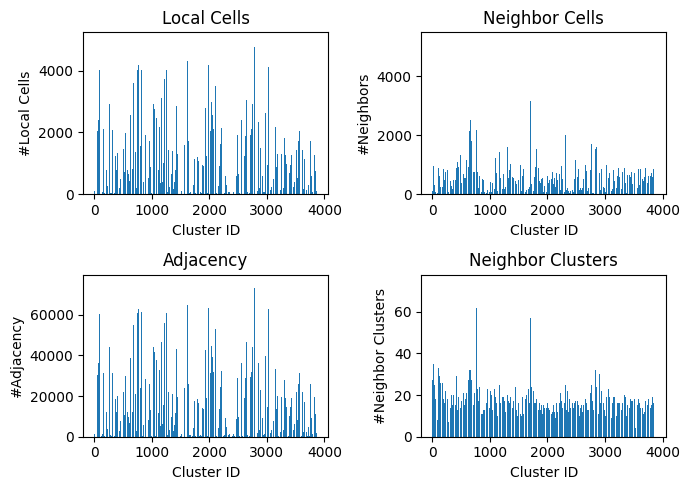

In [12]:
plot_partition_metrics(octree_partition_metrics, save_filename= plots_dir / f"{scene_name}_octree_maxpts_partition_result.pdf")

## Octree with max cluster constraint

In [13]:
indices_octree_w_max_partition = build_octree_max_partitions(points, target_partitions=1024)
print(f"Number of leaf nodes for octree: {len(indices_octree_w_max_partition)}")

Number of leaf nodes for octree: 1030


In [14]:
partitions_octree_w_max_partition= [points[idx] for idx in indices_octree_w_max_partition if len(idx) > 0]

pcd_octree_w_max_partition= visualize_partitions(partitions_octree_w_max_partition, show_bounding_boxes=False)

In [15]:
octree_partition_metrics = compute_all_partition_metrics(
    partition_indices=indices_octree_w_max_partition,
    pts=pts,
    colours=colours,
    density=density,
    adj=adj,
    adj_idx=adj_idx,
    verbose=True
)

part    0:       0 local |      0 neighbours from  0 clusters | adjacency list         0
part  128:   5,025 local |  2,332 neighbours from 16 clusters | adjacency list    76,153
part  256:  20,289 local |  4,520 neighbours from 23 clusters | adjacency list   307,386
part  384:   4,534 local |  1,759 neighbours from 17 clusters | adjacency list    68,402
part  512:   8,386 local |  1,610 neighbours from 14 clusters | adjacency list   127,412
part  640:       2 local |     43 neighbours from 12 clusters | adjacency list        52
part  768:       7 local |     85 neighbours from 11 clusters | adjacency list       144
part  896:   1,553 local |    928 neighbours from 12 clusters | adjacency list    23,475
part 1024:     868 local |    682 neighbours from 10 clusters | adjacency list    13,074
part 1029:   5,911 local |  1,713 neighbours from 12 clusters | adjacency list    89,623


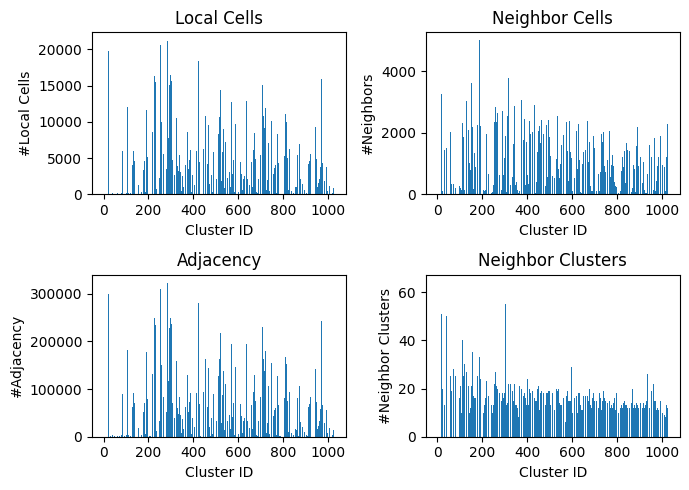

In [16]:
plot_partition_metrics(octree_partition_metrics, save_filename=plots_dir / f"{scene_name}_octree_maxclusters_partition_result.pdf")